In [34]:
from datasets import load_dataset

raw_train_ds = load_dataset("tkarr/sprite_caption_dataset", split="train").take(100)
# raw_val_ds = load_dataset("tkarr/sprite_caption_dataset", split="valid")

raw_train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=65x56>,
 'text': 'Once it takes aim at its foe, it makes a headlong charge. It is famous for its violent nature.'}

In [35]:
from PIL import Image

def scale_image_by_factor(image: Image.Image, factor: float) -> Image.Image | None:
    """Scales a PIL Image down by a factor and returns a new PIL Image.

    Args:
        image: The PIL Image to scale.
        factor: The scaling factor (e.g., 0.5 for half the size).

    Returns:
        A new PIL Image scaled down by the factor, or None if an error occurs.
    """
    try:
        width, height = image.size
        new_width = int(width * factor)
        new_height = int(height * factor)
        scaled_image = image.resize((new_width, new_height), resample=Image.Resampling.NEAREST)
        return scaled_image
    except Exception as e:
        print(f"Error scaling image: {e}")
        return None
    
def scale_image_by_pixel_size(image: Image.Image, pixel_size: int) -> Image.Image | None:
    original_width, original_height = image.size
    if original_width <= original_height:
        # scale by width
        scale_factor = original_width / pixel_size
        new_width = pixel_size
        new_height = int(original_height / scale_factor)
    else:
        # scale by height
        scale_factor = original_height / pixel_size
        new_height = pixel_size
        new_width = int(original_width / scale_factor)
    scaled_image = image.resize((new_width, new_height), resample=Image.Resampling.NEAREST)
    return scaled_image

In [36]:
from pandas import DataFrame

train_df = DataFrame(raw_train_ds)
train_df.head(3)

,image,text
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"Once it takes aim at its foe, it makes a headl..."
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,Their tusks can shatter rocks. Territory battl...
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,The spot patterns on its back grow larger or s...


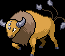

In [37]:
from PIL import Image
from IPython.display import display

def get_image(ds, index):
    return ds[index]["image"]

first_image: Image.Image = get_image(raw_train_ds, 0)
display(first_image)

In [38]:
import torch
from torchvision.transforms import v2

SIZE = 64

transform = v2.Compose([
    v2.Lambda(lambda x: x.convert("RGB")),
    v2.Lambda(lambda x: scale_image_by_pixel_size(x, SIZE)),
    v2.CenterCrop((SIZE, SIZE)),
    v2.ToTensor(),
])

def preprocess(examples):
    tensors = [transform(image) for image in examples["image"]]
    return {"tensor": torch.stack(tensors)}

train_ds = raw_train_ds.map(preprocess, batched=True)
train_ds.set_format(type="torch", columns=["tensor"])

/Users/harry.sadler/Library/Caches/pypoetry/virtualenvs/pixelart-dataset-exploration-iWfMpuw5-py3.12/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [39]:
train_ds[0]["tensor"].shape

torch.Size([3, 64, 64])

In [40]:
from matplotlib import pyplot as plt

def viz_compare_images(img1: Image.Image, img2: Image.Image):
    _, axes = plt.subplots(1, 2, figsize=(12, 6))
    a: plt.Axes = axes[0]
    a.imshow(img1)
    a.set_title('Image 1')
    a.axis('off')
    a: plt.Axes = axes[1]
    a.imshow(img2)
    a.set_title('Image 2')
    a.axis('off')

In [41]:
from torchvision.transforms import ToPILImage
import ipywidgets as widgets

def show_image(index):
    t: torch.Tensor = train_ds[index]["tensor"]
    pil_image = ToPILImage()(t)
    viz_compare_images(get_image(raw_train_ds, index), pil_image)

image_slider = widgets.IntSlider(
    min=0,
    max=len(raw_train_ds) - 1,
    step=1,
    description='Image Index:',
    value=0
)

widgets.interactive(show_image, index=image_slider)


interactive(children=(IntSlider(value=0, description='Image Index:', max=99), Output()), _dom_classes=('widget…